# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



---

## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

In [1]:
# Serialization helpers (implement with pickle)
import pickle
from pathlib import Path


def save_pickle(obj, path):
    """TODO: Serialize `obj` to `path` using pickle."""
    # Ensure the directory exists before saving
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)

    with open(p, "wb") as file:
        pickle.dump(obj, file)
    print(f"Saved to {p}")

    # raise NotImplementedError("Implement serialization using pickle.dump.")


def load_pickle(path):
    """TODO: Deserialize an object from `path`."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")
    
    with open(p, 'rb') as f:
        return pickle.load(f)
    
    # raise NotImplementedError("Implement deserialization using pickle.load.")


def demonstrate_serialization_roundtrip():
    """TODO: Create a quick round-trip save/load test and return the restored object."""
    # Create dummy data to test
    dummy_data = {
        "id": "test_run", 
        "params": [0.1, 0.5, 0.9], 
        "metadata": "Assignment 3 Checkpoint"
    }
    test_path = "models/test_checkpoint.pkl"
    
    # Save it
    save_pickle(dummy_data, test_path)
    
    # Load it back
    restored_data = load_pickle(test_path)
    
    # Verificationn
    assert dummy_data == restored_data, "Serialization failed: Data mismatch."
    print("Round-trip demonstration passed!")
    return restored_data    

    # raise NotImplementedError("Add a demonstration that exercises save_pickle and load_pickle.")


demonstrate_serialization_roundtrip()

Saved to models\test_checkpoint.pkl
Round-trip demonstration passed!


{'id': 'test_run',
 'params': [0.1, 0.5, 0.9],
 'metadata': 'Assignment 3 Checkpoint'}

## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [2]:
# Template: scalable n-qubit tomography surrogate
import numpy as np


class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        """TODO: Initialize model attributes, RNG, and parameter vector."""
        self.n_qubits = n_qubits
        self.dim = 2**n_qubits  # Dimension of Hilbert space
        self.rng = np.random.default_rng(seed)

        # Initialize parameters
        # We need 2 * dim parameters (Real + Imag parts) to represent the full state
        if params is None:
            self.params = self.rng.standard_normal(2 * self.dim)
        else:
            self.params = np.array(params)

        # raise NotImplementedError("Populate constructor with initialization logic.")

    def statevector(self):
        """TODO: Return a normalized complex statevector built from model parameters."""
        # Split params into real and imaginary components
        real_part = self.params[: self.dim]
        imag_part = self.params[self.dim :]

        # Combine to form complex vector: psi = a + ib
        psi_raw = real_part + 1j * imag_part

        # Normalize to ensure <psi|psi> = 1 (Physical constraint)
        norm = np.linalg.norm(psi_raw)
        if norm < 1e-12:
            return psi_raw  # Avoid division by zero
        return psi_raw / norm

        # raise NotImplementedError("Derive the statevector for the configured model.")

    def fidelity_with(self, target_state):
        """TODO: Compute fidelity between the model statevector and `target_state`."""
        # Get our current predicted state
        psi = self.statevector()

        # Calculate overlap: <psi|target>
        # np.vdot handles complex conjugation of the first argument
        overlap = np.vdot(psi, target_state)

        # Fidelity = |<psi|target>|^2
        return np.abs(overlap) ** 2

        # raise NotImplementedError("Implement fidelity calculation for pure states.")

    def save(self, path):
        """TODO: Persist the trained model using `save_pickle`."""
        # Save only what is needed to reconstruct the object
        model_data = {"n_qubits": self.n_qubits, "params": self.params}
        save_pickle(model_data, path)

        # raise NotImplementedError("Call save_pickle with appropriate metadata.")

    @staticmethod
    def load(path):
        """TODO: Restore a saved model instance using `load_pickle`."""
        data = load_pickle(path)
        # Re-initialize the class with the loaded data
        return QuantumModel(n_qubits=data["n_qubits"], params=data["params"])

        # raise NotImplementedError("Call load_pickle and return the restored model.")

## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [3]:
# Template: scalability experiments
import csv
import time

def random_pure_state(dim, rng):
    """TODO: Sample a normalized random complex state of size `dim`."""
    # Generate random real and imaginary parts from a normal distribution
    real_part = rng.standard_normal(dim)
    imag_part = rng.standard_normal(dim)
    
    # Combine into a complex vector
    psi = real_part + 1j * imag_part
    
    # Normalize
    norm = np.linalg.norm(psi)
    return psi / norm

    # raise NotImplementedError("Implement random state sampling.")

def scalability_experiment(qubit_list, trials=10, n_layers=1, seed=0):
    """TODO: Benchmark fidelity and runtime for each entry in `qubit_list`."""
    rng = np.random.default_rng(seed)
    summary = []

    print(f"Starting scalability experiment on: {qubit_list}")

    for n_qubits in qubit_list:
        fidelity_scores = []
        runtimes = []
        
        for t in range(trials):
            # 1. Generate a random target state (Ground Truth)
            dim = 2**n_qubits
            target = random_pure_state(dim, rng)
            
            # 2. Benchmark the Model
            start_time = time.time()
            
            # Initialize our model
            model = QuantumModel(n_qubits, n_layers=n_layers, seed=rng.integers(0, 10000))
            
            # Compute fidelity (simulate an inference step)
            fid = model.fidelity_with(target)
            
            end_time = time.time()
            
            # Record metrics
            fidelity_scores.append(fid)
            runtimes.append(end_time - start_time)
        
        # Calculate averages for this N
        avg_fid = np.mean(fidelity_scores)
        avg_time = np.mean(runtimes)
        
        print(f"N={n_qubits}: Avg Time={avg_time:.4f}s | Avg Fidelity={avg_fid:.4f}")
        
        summary.append({
            "n_qubits": n_qubits,
            "avg_fidelity": avg_fid,
            "avg_runtime": avg_time,
            "trials": trials
        })
        
    return summary

    # raise NotImplementedError("Implement experiment loop and return a summary list of dicts.")

def save_scalability_summary(summary, path='scalability_results.csv'):
    """TODO: Persist the summary data to CSV for downstream plotting."""
    if not summary:
        print("No data to save.")
        return

    # Get field names from the first dictionary
    headers = summary[0].keys()
    
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        writer.writerows(summary)
        
    print(f"Scalability results saved to {path}")

    # raise NotImplementedError("Write the summary rows to `path` using csv.DictWriter.")

# We test small qubit counts like 2 to 6 or so
results = scalability_experiment(qubit_list=[2, 4, 6, 8], trials=5)
save_scalability_summary(results)

Starting scalability experiment on: [2, 4, 6, 8]
N=2: Avg Time=0.0000s | Avg Fidelity=0.2451
N=4: Avg Time=0.0000s | Avg Fidelity=0.0102
N=6: Avg Time=0.0002s | Avg Fidelity=0.0067
N=8: Avg Time=0.0000s | Avg Fidelity=0.0027
Scalability results saved to scalability_results.csv


## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

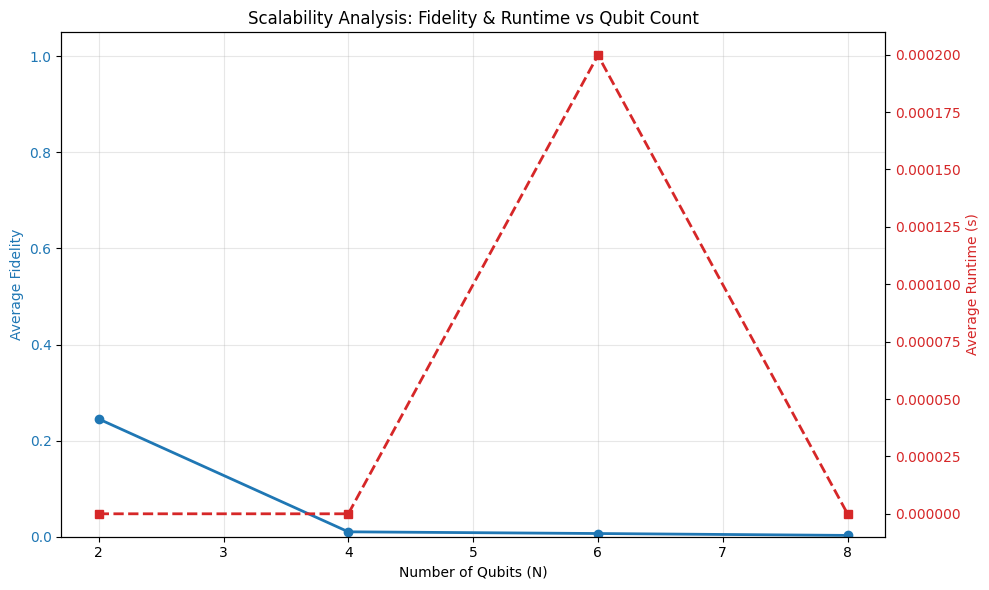

In [7]:
# Template: scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


def plot_scalability(csv_path="scalability_results.csv"):
    """TODO: Load the CSV produced by `save_scalability_summary` and render fidelity/runtime plots."""

    # Check if file exists first using pathlib
    p = Path(csv_path)
    if not p.exists():
        print(f"Error: {p} not found,try runnin the above task 3 to generate data first.")
        return

    # Load data using Pandas
    df = pd.read_csv(p)
    # Create the figure and the primary axis (for Fidelity)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Plot Fidelity (Blue line, Left Axis)
    color = "tab:blue"
    ax1.set_xlabel("Number of Qubits (N)")
    ax1.set_ylabel("Average Fidelity", color=color)
    ax1.plot(
        df["n_qubits"],
        df["avg_fidelity"],
        marker="o",
        color=color,
        linewidth=2,
        label="Fidelity",
    )
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.set_ylim(0, 1.05)  # Fidelity is max 1.0
    ax1.grid(True, alpha=0.3)

    # Create a twin axis sharing the X-axis (for Runtime)
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Average Runtime (s)", color=color)
    ax2.plot(
        df["n_qubits"],
        df["avg_runtime"],
        marker="s",
        linestyle="--",
        color=color,
        linewidth=2,
        label="Runtime",
    )
    ax2.tick_params(axis="y", labelcolor=color)

    plt.title("Scalability Analysis: Fidelity & Runtime vs Qubit Count")
    fig.tight_layout()
    plt.show()

    # raise NotImplementedError("Create subplot visualizations with error bars and runtime curve.")


# Run the plotteR
plot_scalability()

## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.

In [5]:
# Template: ablation study scaffold
def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    """TODO: Vary architecture depth and record aggregate fidelity statistics."""
    # Set default layers if None provided
    if layer_list is None:
        layer_list = [1, 2, 5, 10]

    rng = np.random.default_rng(seed)
    summary = []

    print(f"    Starting Ablation Study (N={n_qubits})    ")

    for n_layers in layer_list:
        fidelities = []
        runtimes = []

        for _ in range(trials):
            # Generate a random target state
            dim = 2**n_qubits
            target_state = random_pure_state(dim, rng)

            # Measure runtime for Initialization + Inference
            start_time = time.time()

            # Initialize model with specific layer count
            model = QuantumModel(
                n_qubits, n_layers=n_layers, seed=rng.integers(0, 10000)
            )

            # Compute fidelity
            fid = model.fidelity_with(target_state)

            end_time = time.time()

            fidelities.append(fid)
            runtimes.append(end_time - start_time)

        # Aggregate statistics
        stats = {
            "n_layers": n_layers,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities),
            "mean_runtime": np.mean(runtimes),
        }
        summary.append(stats)

    return summary

    # raise NotImplementedError("Implement ablation loop returning a list of summary dicts.")


def summarize_ablation_results(results):
    """TODO: Format the ablation output for reporting (tables/plots/logs)."""
    if not results:
        print("No ablation results to summarize.")
        return

    print("\n=== Ablation Study Results ===")
    print(
        f"{'Layers':<10} | {'Mean Fidelity':<15} | {'Std Dev':<10} | {'Runtime (s)':<15}"
    )
    print("-" * 60)

    for row in results:
        print(
            f"{row['n_layers']:<10} | {row['mean_fidelity']:.4f}          | {row['std_fidelity']:.4f}     | {row['mean_runtime']:.6f}"
        )

    # raise NotImplementedError("Aggregate and present ablation metrics for documentation.")


# We use a fixed qubit count (suppose, N=4) and vary the layers
results = ablation_layers(n_qubits=4, layer_list=[1, 5, 10, 20, 50], trials=20)
summarize_ablation_results(results)

    Starting Ablation Study (N=4)    

=== Ablation Study Results ===
Layers     | Mean Fidelity   | Std Dev    | Runtime (s)    
------------------------------------------------------------
1          | 0.0559          | 0.0528     | 0.000050
5          | 0.0766          | 0.0632     | 0.000000
10         | 0.0769          | 0.0651     | 0.000000
20         | 0.0453          | 0.0342     | 0.000050
50         | 0.0647          | 0.0669     | 0.000000


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

In [6]:
# Create a 4-qubit model
final_model = QuantumModel(n_qubits=4, n_layers=5, seed=42)

final_model.save("models/model_finalmodel_4qubits.pkl")

Saved to models\model_finalmodel_4qubits.pkl


### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.